# Kopia av 4_💪_Stort_test.py för tester

In [ ]:


sys.path.append(
    'C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\')
pref = '../'

import json
import travdata as td
import typ_copy as tp
import sys
import time
import concurrent.futures
from catboost import CatBoostClassifier, Pool
import pickle
# import streamlit as st
import numpy as np
import pandas as pd
from IPython.display import display
# import V75_scraping as vs
# from sklearn.ensemble import RandomForestRegressor
# import datetime
# import sklearn
import matplotlib.pyplot as plt
plt.style.use('ggplot')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 260)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 120)


# st.set_page_config(page_title="Stort test av modeller", page_icon="💪")

# st.markdown("# 💪 Stort test av modeller")
# st.sidebar.header("💪 Stort test")


In [62]:

def välj_rad_orginal(df_meta_predict, max_insats=300):
    veckans_rad = df_meta_predict.copy()
    veckans_rad['välj'] = False   # inga rader valda ännu

    # first of all: select one horse per avd
    for avd in veckans_rad.avd.unique():
        max_pred = veckans_rad[veckans_rad.avd == avd]['meta_predict'].max()
        veckans_rad.loc[(veckans_rad.avd == avd) & (
            veckans_rad.meta_predict == max_pred), 'välj'] = True
    # veckans_rad.query("välj==True").to_csv('veckans_basrad.csv')
    veckans_rad = veckans_rad.sort_values(by=['meta_predict'], ascending=False)
    veckans_rad = veckans_rad.reset_index(drop=True)

    mest_diff = 0
    #mest_diff = mesta_diff_per_avd(veckans_rad)

    cost = 0.5  # 1 rad

    # now select the rest of the horses one by one sorted by meta_predict
    for i, row in veckans_rad.iterrows():
        if row.avd == mest_diff.avd.iloc[0]:
            continue
        if row.avd == mest_diff.avd.iloc[1]:
            continue
        # print('i',i)
        veckans_rad.loc[i, 'välj'] = True
        #cost = compute_total_insats(veckans_rad[veckans_rad.välj])
        # print('cost',cost)
        if cost > max_insats:
            # veckans_rad.loc[i, 'välj'] = False
            break

    # print('cost', cost_before)
    veckans_rad.sort_values(by=['välj', 'avd'], ascending=[
                            False, True], inplace=True)
    # display(veckans_rad[veckans_rad.välj])
    return veckans_rad


def compute_total_insats(veckans_rad):
    summa = veckans_rad.groupby('avd').avd.count().prod() / 2
    return summa


In [63]:


def starta_upp(df, start_ix=220):
    import datetime

    startdatum = df.datum.unique()[start_ix]

    print("st.info(f'Startdatum = {startdatum}'")

    # init resutat-tabell
    df_resultat = pd.DataFrame(columns=['datum', 't1_vinst', 't2_vinst', 't3_vinst', 't4_vinst',
                                                 't1_utd',   't2_utd',   't3_utd',   't4_utd',
                                                 't1_kostn', 't2_kostn', 't3_kostn', 't4_kostn',
                                                 't1_7', 't2_7', 't3_7', 't4_7',
                                                 't1_6', 't2_6', 't3_6', 't4_6',
                                                 't1_5', 't2_5', 't3_5', 't4_5'
                                        ])

    df_resultat.set_index('datum', drop=True, inplace=True)
    # print(df_resultat.head(0))
    df_resultat.loc[startdatum] = [0, 0, 0, 0, 0, 0,
                                   0, 0, 0, 0, 0, 0,
                                   0, 0, 0, 0, 0, 0,
                                   0, 0, 0, 0, 0, 0]

    return df.datum.unique(), df_resultat



In [64]:

def skapa_data_för_datum(df_, datum):
    df = df_.copy()
    X = df.query(f'datum < @datum')
    y = X.y
    X = X.drop('y', axis=1)
    X_test = df.query(f'datum > @datum')
    y_test = X_test.y
    X_test = X_test.drop('y', axis=1)
    X_curr = df.query(f'datum == @datum')
    y_curr = X_curr.y
    X_curr = X_curr.drop(['y'], axis=1)
    return X, y, X_test, y_test, X_curr, y_curr

    from sklearn.ensemble import RandomForestRegressor as rf



In [65]:

def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    # läs in streck_to_odds.pkl
    import pickle
    with open(pref+'rf_streck_odds.pkl', 'rb') as f:
        rf = pickle.load(f)

    if odds is None:
        o = rf.predict(streck.copy())
    else:
        o = rf.predict(streck.copy())

    # for each values > 40 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o


def compute_total_insats(veckans_rad):
    summa = veckans_rad.groupby('avd').avd.count().prod() / 2
    return summa


def beräkna_utdelning(datum, sjuor, sexor, femmor, df_utdelning):
    datum = datum.strftime('%Y-%m-%d')

    min_utdelning = df_utdelning.loc[df_utdelning.datum == datum, [
        '7rätt', '6rätt', '5rätt']]

    return (min_utdelning['7rätt'] * sjuor + min_utdelning['6rätt'] * sexor + min_utdelning['5rätt'] * femmor).values[0]


def varje_avd_minst_en_häst(veckans_rad):
    # ta ut en häst i varje avd - markera valda i df
    for avd in veckans_rad.avd.unique():
        # max av proba i veckans_rad
        max_proba = veckans_rad[veckans_rad.avd == avd]['proba'].max()
        veckans_rad.loc[(veckans_rad.avd == avd) & (
            veckans_rad.proba == max_proba), 'välj'] = True
    return veckans_rad


def hitta_spikar(veckans_rad, spikad_avd, spik_strategi, min_avst):
    print('spik_strategi', spik_strategi)
    assert spik_strategi in [
        '1a', '1b', '2a', '2b'], "spik_strategi måste ha något av värdena i listan"
    # Hitta spik-kandidater
    if spik_strategi[0] in ['1', '2']:
        ix_spik1 = veckans_rad.nlargest(
            1, 'proba').index[0]   # ix for largest in dataset
        # avd med högsta proba totalt
        avd = veckans_rad.loc[ix_spik1, 'avd']
        no2 = veckans_rad.query("avd==@avd").nlargest(2,
                                                      'proba').index[1]  # second i avd ovan
        # print(
        #     f'hösta proba totalt={veckans_rad.loc[ix_spik1, "proba"]} finns i avd={avd}; no2 i avd={avd} är {veckans_rad.loc[no2,"proba"]}')
        avstånd = veckans_rad.loc[ix_spik1, 'proba'] - \
            veckans_rad.loc[no2, 'proba']
        print('avst', avstånd)
        if (spik_strategi[1] == 'b') and (avstånd > min_avst):  # spik 1 om stort avst
            print('strategi', spik_strategi[1], 'valde spik i avd', avd)
            spikad_avd.append(avd)      # add avd to a list

            veckans_rad.loc[ix_spik1, 'spik'] = True
            veckans_rad.loc[ix_spik1, 'välj'] = True
        elif spik_strategi[1] == 'a':   # forcerad spik 1
            print('strategi', spik_strategi[1], 'valde spik i avd', avd)
            spikad_avd.append(avd)      # add avd to a list
            veckans_rad.loc[ix_spik1, ['spik']] = True
            veckans_rad.loc[ix_spik1, 'välj'] = True

    if spik_strategi[0] == '2':
        spik2 = veckans_rad.nlargest(2, 'proba').index[1]  # second in dataset
        avd = veckans_rad.loc[spik2, 'avd']
        no2 = veckans_rad.query("avd==@avd").nlargest(2,
                                                      'proba').index[1]  # second in avd
        # print(
        #     f'näst högsta proba totalt={veckans_rad.loc[spik2, "proba"]} finns i avd={avd}; no2 i avd={avd} är {veckans_rad.loc[no2,"proba"]}')
        avstånd = veckans_rad.loc[spik2, 'proba'] - \
            veckans_rad.loc[no2, 'proba']
        print('avst', avstånd)
        # spik om stort avstånd till 2:an
        if (spik_strategi[1] == 'b') and (avstånd > min_avst):
            print('strategi', spik_strategi[1], 'valde spik i avd', avd)
            spikad_avd.append(avd)
            veckans_rad.loc[spik2, 'spik'] = True
            veckans_rad.loc[spik2, 'välj'] = True
        elif spik_strategi[1] == 'a':   # forcerad spik 2
            print('strategi', spik_strategi[1], 'i avd', avd)
            spikad_avd.append(avd)
            veckans_rad.loc[spik2, 'spik'] = True
            veckans_rad.loc[spik2, 'välj'] = True
    return veckans_rad, spikad_avd



In [66]:

def plocka_en_efter_en(veckans_rad, spikad_avd, kelly_strategi, max_cost=300):
    """_summary_
    Args:
        veckans_rad (_type_): df att fylla
        spikad_avd (_type_): lista med spikade avdelningar
        kelly_strategi (_type_): 1 välj med Kelly varannan gång, annars ingen Kelly
        max_cost (int, optional): Max kostnad. Defaults to 300.

    Returns:
        _type_: df med veckans rad samt kostnad
    """
    cost = 0.5  # 1 rad
    while cost < max_cost:
        # d) plocka en och en - först proba sedan ev positiv kelly markera som valda i df
        curr_index = veckans_rad.query(
            "välj==False and avd not in @spikad_avd").nlargest(1, 'proba').index
        veckans_rad.loc[curr_index, 'välj'] = True
        # e) avbryt vid 300:-
        cost = compute_total_insats(veckans_rad.query("välj==True"))
        if cost > max_cost:
            # ta tillbaks den sist spelade
            veckans_rad.loc[curr_index, 'välj'] = False
            break

        if kelly_strategi == 1:
            veckans_kelly = veckans_rad.query(
                "välj==False and kelly > 0 and avd not in @spikad_avd ")
            veckans_kelly = veckans_kelly.sort_values(
                by=['kelly'], ascending=False)
            try:
                True
                # print('kelly')
            except:
                print('no kelly', veckans_kelly.shape)

            if veckans_kelly.iloc[0]['kelly'] > 0:
                curr_index = veckans_kelly.iloc[0].name
                veckans_rad.loc[curr_index, 'välj'] = True
                veckans_rad.loc[curr_index, 'kelly_val'] = True
                cost = compute_total_insats(veckans_rad.query("välj==True"))

            if cost > max_cost:
                # ta tillbaks den sist spelade
                veckans_rad.loc[curr_index, 'välj'] = False
                break
    cost = compute_total_insats(veckans_rad.query("välj==True"))

    return veckans_rad, cost


def ta_fram_rad(veckans_rad_, spik_strategi, kelly_strategi, max_cost=300, min_avst=0.175):
    """ Denna funktion tar fram en rad för typ-modeller (ej meta-modell)
    df nnehåller _en omgång_
    _spik_strategi_: None - inget, '1a' - forcera 1 spik, '2a' - forcera 2 spikar, '1b' - 1 spik endast om klar favorit, '2b' - spikar för endast klara favoriter 
    _kelly_strategi_: None - ingen kelly, 1 - kelly varannan gång om positiv
    """
    veckans_rad = veckans_rad_.copy()
    veckans_rad['kelly_val'] = False
    veckans_rad['välj'] = False   # inga rader valda ännu
    veckans_rad['spik'] = False   # inga spikar valda ännu

    veckans_rad = varje_avd_minst_en_häst(veckans_rad)

    # b) leta 1-2 spikar om så begärs - markera valda i df
    spikad_avd = []
    if spik_strategi:
        veckans_rad, spikad_avd = hitta_spikar(
            veckans_rad, spikad_avd, spik_strategi, min_avst)

    # c) sortera upp i proba-ordning. Om kelly skapa en sortering efter kelly-ordning
    veckans_rad = veckans_rad.sort_values(by=['proba'], ascending=False)
    veckans_rad = veckans_rad.reset_index(drop=True)

    # plocka en efter en tills kostnaden är för stor
    # return veckans_rad, cost
    return plocka_en_efter_en(veckans_rad, spikad_avd, kelly_strategi, max_cost)



In [67]:

def rätta_rad(df, datum, df_utdelning):
    """
    Räkna ut antal 5:or, 6:or resp. 7:or
    Hämta ev utdelning
    Spara datum, resultat, utdelning och rad-kostnad
    """
    sjuor, sexor, femmor, utdelning = 0, 0, 0, 0

    min_tabell = df[['y', 'avd', 'häst', 'rel_rank', 'välj']].copy()
    min_tabell.sort_values(by=['avd', 'y'], ascending=False, inplace=True)

    print('Antal rätt', min_tabell.query('välj==True and y==1').y.sum())
    display(min_tabell)
    
    # 1. om jag har max 7 rätt
    if min_tabell.query('välj==True and y==1').y.sum() == 7:
        sjuor = 1
        sexor = (min_tabell.groupby('avd').välj.sum()).sum()-7
        # antal femmor
        ant1 = min_tabell.query('avd==1 and välj==True').välj.sum()-1
        ant2 = min_tabell.query('avd==2 and välj==True').välj.sum()-1
        ant3 = min_tabell.query('avd==3 and välj==True').välj.sum()-1
        ant4 = min_tabell.query('avd==4 and välj==True').välj.sum()-1
        ant5 = min_tabell.query('avd==5 and välj==True').välj.sum()-1
        ant6 = min_tabell.query('avd==6 and välj==True').välj.sum()-1
        ant7 = min_tabell.query('avd==7 and välj==True').välj.sum()-1
        femmor = ant1*ant2+ant1*ant2+ant1*ant3+ant1*ant4+ant1*ant5+ant1*ant6+ant1*ant7 +\
            ant2*ant3+ant2*ant4+ant2*ant5+ant2*ant6+ant2*ant7 + \
            ant3*ant4+ant3*ant5+ant3*ant6+ant3*ant7 + \
            ant4*ant5+ant4*ant6+ant4*ant7 + \
            ant5*ant6+ant5*ant7 + \
            ant6*ant7

    # 2. om jag har max 6 rätt
    if min_tabell.query('välj==True and y==1').y.sum() == 6:
        avd_fel = min_tabell.loc[((min_tabell.välj == False) & (
            min_tabell.y == 1)), 'avd'].values[0]
        print(min_tabell.query('avd== @avd_fel').välj.sum())
        sexor = min_tabell.query('avd==@avd_fel').välj.sum()
        # antal femmor
        femmor_fel, femmor_rätt = 0, 0
        for avd in range(1, 8):
            if avd == avd_fel:
                femmor_fel += min_tabell.loc[min_tabell.avd ==
                                             avd_fel].välj.sum()

            femmor_rätt += min_tabell.query(
                'avd==@avd and välj==True').välj.sum()-1
        print(f'femmor_rätt = {femmor_rätt} femmor_fel = {femmor_fel}')
        femmor = femmor_fel * femmor_rätt

    # 3. om jag har max 5 rätt
    if min_tabell.query('välj==True and y==1').y.sum() == 5:
        avd_fel = min_tabell.loc[((min_tabell.välj == False) & (
            min_tabell.y == 1)), 'avd'].values
        femmor = min_tabell.loc[min_tabell.avd == avd_fel[0]].välj.sum(
        ) * min_tabell.loc[min_tabell.avd == avd_fel[1]].välj.sum()

    return sjuor, sexor, femmor, beräkna_utdelning(datum, sjuor, sexor, femmor, df_utdelning)


def initiera_veckans_rader(X_curr, y_curr, antal_rader):
    # ---------- initier veckans rad med aktuell omgång ----------------------
    veckans_rader = []
    for i in range(antal_rader):
        veckans_rader.append(X_curr[['datum', 'avd', 'häst', 'bana',
                                     'kusk', 'streck', 'streck_avst', 'rel_rank']].copy())
        veckans_rader[i]['y'] = y_curr
        veckans_rader[i]['välj'] = False

    return veckans_rader



In [68]:

def predict_curr_omgang(model, X_curr, y_curr, veckans_rad):
    # ------------- predict aktuell omgång och skapa Kelly -------------------

    veckans_rad['proba'] = model.predict(X_curr)

    veckans_rad['kelly'] = kelly(
        veckans_rad.proba.copy(), veckans_rad[['streck']].copy(), None)

    return veckans_rad


def learn_and_predict(modeller, X, y, X_test, y_test, X_curr, y_curr):

    veckans_rader = initiera_veckans_rader(X_curr, y_curr, len(modeller))

    params = {"depth": 2, "l2_leaf_reg": 3,
              "iterations": 500, "learning_rate": 0.008}

    # learn and predict all models
    for enum, model in enumerate(modeller):
        the_params = params.copy()
        save = True

        model.learn(X, y, X_test_=X_test, y_test=y_test,
                    save=save, params=the_params)
        modeller[enum] = model

        # print('X_shape', X.shape)
        # print('X_curr.shape', X_curr.shape, 'X_test.shape', X_test.shape)

        veckans_rader[enum] = predict_curr_omgang(
            model, X_curr, y_curr, veckans_rader[enum])

    return veckans_rader


def backtest(df, df_resultat, modeller, predictors, datumar, gap=0, proba_val=0.6, start_ix=220, step=1):
    """ Backtesting anpassad för travets omgångar, dvs datum istf dagar"""

    placeholder0 = "st.empty()"
    placeholder1 = "st.empty()"
    placeholder2 = "st.empty()"
    placeholder3 = "st.empty()"

    df_utdelning = pd.read_csv('utdelning.csv')

    for curr_datum_ix in range(start_ix, len(datumar), step):
        datum = datumar[curr_datum_ix]
        # placeholder0.empty()
        # placeholder0.info(
        print(f'Aktuell datum: {datum} {"        "} \nant_omgångar spelade: {curr_datum_ix}')

        X, y, X_test, y_test, X_curr, y_curr = skapa_data_för_datum(df, datum)
        if X.empty or X_test.empty or X_curr.empty:
            break

        print(f'learn fram till {datum}')
        veckans_rader = learn_and_predict(
            modeller, X, y, X_test, y_test, X_curr, y_curr)

        #### speciellt for stacking ####
        # ------------- Predict senare datum och skapa en stack ------------------
        # ------------- learn meta-modeller på stacken från predict ovan ---------
        # ------------- skapa en stack av den aktuella omgången ----------------
        # ------------- skapa predict med meta-modellerna ----------------------
        # ------ inkludera predict i veckans_rad för varje meta-modell ---------
        # ------------- ta fram rad för aktuell omgång med meta-predicterna ----
        # ------------- Använd spik- och kelly-strategi ------------------------
        #### speciellt for stacking ####

        spik_strategier = ['2b', '2b', None, '2b', None]
        kelly_strategier = [None, None, 1, 1, None]

        # ta fram rader och rättaa dem
        femmor, sexor, sjuor, utdelning, kostnad, vinst = [], [], [], [], [], []
        last_row = df_resultat.iloc[-1]
        for enum, veckans_rad in enumerate(veckans_rader):
            veckans_rad, cost = ta_fram_rad(
                veckans_rad, spik_strategier[enum], kelly_strategier[enum], min_avst=0.178)
            kostnad.append(cost)
            sju, sex, fem, utd = rätta_rad(veckans_rad, datum, df_utdelning)
            sjuor.append(int(sju))
            sexor.append(int(sex))
            femmor.append(int(fem))
            utdelning.append(int(utd))
            vinst.append(utdelning[enum] - kostnad[enum])
            veckans_rader[enum] = veckans_rad
        assert len(vinst) == len(
            veckans_rader), f"len(vinst)={len(vinst)} är inte lika med len(veckans_rader={len(veckans_rader)}"

        last_row +=vinst + utdelning + kostnad + sjuor + sexor +  femmor
    
        df_resultat.loc[datum] = last_row

        df_resultat.to_csv('backtest_resultat.csv', index=True)

        # 3. plotta
        graf_data = df_resultat.copy()

        # graf_data.index = pd.to_datetime(graf_data.index, format="%Y-%m-%d")

        """placeholder1.empty()
        placeholder2.empty()
        placeholder3.empty()"""

        # Backtest klart och nu plot
        # placeholder1.line_chart(graf_data[[
            
        # make a line chart of graf_data. Do NOT use the streanlit here.
        import matplotlib.pyplot as plt
        plt.plot(graf_data[[
            't1_vinst', 't2_vinst', 't3_vinst', 't4_vinst']])
        
        
        
        
        # placeholder2.line_chart(graf_data[[
        #                         't1_7', 't2_7', 't3_7', 't4_7']], width=0, height=0, use_container_width=True)

        # st.write(df_resultat.plot(kind='line',  y='t1_vinst', rot=45, legend=True, figsize=(20,10)))
        """placeholder3.dataframe(df_resultat.tail(40))"""
        
        df_resultat.sort_index(ascending=False).head(40)
    return veckans_rader


In [69]:


def kör(df, modeller):
    df_utdelning = pd.read_csv('utdelning.csv')
    start_ix = 220  # antal omgångar som vi startar från i backtesting

    ##################################################################################
    # Bestäm i förväg vilka predictors som varje meta-model skall använda            #
    # Bestäm också spik-strategi och kelly-strategi för varje meta-model             #
    # Kanske en dict är bra?                                                         #
    ##################################################################################

    datumar, df_resultat = starta_upp(df, start_ix)
    predictors = []

    # backtesting
    veckans_rader = backtest(df, df_resultat, modeller,
                             predictors, datumar, gap=0, proba_val=0.6, start_ix=220, step=1)

    # step=1
    # for curr_datum_ix in range(start_ix,len(datumar), step):

    #     datum = datumar[curr_datum_ix]
    #     placeholderdat.empty()
    #     if curr_datum_ix > 0:
    #         placeholderdat.info(
    #             f'Aktuell datum: {  datum} {"        "} \nant_omgångar spelade: {curr_datum_ix-start_ix}')

    #     # 1. learn fram till datum
    #     # 1a. skapa train och test dataframes samt aktuell omgång som vi predictar - returnerar df_train, df_test, df_curr
    #     X, y, X_test, y_test, X_curr, y_curr = skapa_data_för_datum(df, datum)
    #     if X.empty or X_test.empty or X_curr.empty:
    #         break

    # ---------- initier veckans rad med aktuell omgång ----------------------
    # veckans_rad1 = X_curr[['datum', 'avd', 'häst', 'bana',
    #                        'kusk', 'streck', 'streck_avst', 'rel_rank']].copy()
    # veckans_rad1['y'] = y_curr
    # veckans_rad2 = X_curr[['datum', 'avd', 'häst', 'bana',
    #                        'kusk', 'streck', 'streck_avst', 'rel_rank']].copy()
    # veckans_rad2['y'] = y_curr
    # veckans_rad3 = X_curr[['datum', 'avd', 'häst', 'bana',
    #                        'kusk', 'streck', 'streck_avst', 'rel_rank']].copy()
    # veckans_rad3['y'] = y_curr
    # veckans_rad4 = X_curr[['datum', 'avd', 'häst', 'bana',
    #                        'kusk', 'streck', 'streck_avst', 'rel_rank']].copy()
    # veckans_rad4['y'] = y_curr

    # ------------- Learn modeller ------------------------------------------
    # Learn fram till en tidigare datum för att knna skapa en stack till meta-modellerna
    # print(f'learn fram till {datum}')
    # params = {"depth": 2, "l2_leaf_reg": 3,
    #           "iterations": 500, "learning_rate": 0.008}
    # model1 = modeller[0].learn(X, y, X_test_=X_test,
    #                      y_test=y_test, save=True, params=params.copy())
    # model2 = modeller[1].learn(X, y, X_test_=X_test,
    #                      y_test=y_test, save=True, params=params.copy())
    # model3 = modeller[2].learn(X, y, X_test_=X_test,
    #                      y_test=y_test, save=True, params=params.copy())
    # with open('optimera/params_'+modeller[3].name+'.json', 'r') as f:
    #     params6 = json.load(f)
    #     params6 = params6['params']
    # # don't save. Use model4.predict() instead
    # model4 = modeller[3].learn(X, y, X_test_=X_test,
    #                     y_test=y_test, save=False,  params=params6)
    # print('X_shape', X.shape)
    # print('X_curr.shape', X_curr.shape, 'X_test.shape', X_test.shape)

    # ------------- Predict senare datum och skapa en stack ------------------

    # ------------- learn meta-modeller på stacken från predict ovan ---------

    # ------------- predict aktuell omgång och skapa Kelly -------------------
    # veckans_rad1['kelly'] = kelly(
    #     veckans_rad1.proba.copy(), veckans_rad1[['streck']].copy(), None)
    # veckans_rad2['proba'] = test2.predict(X_curr)
    # veckans_rad2['kelly'] = kelly(
    #     veckans_rad2.proba.copy(), veckans_rad2[['streck']].copy(), None)

    # veckans_rad3['proba'] = test3.predict(X_curr)
    # veckans_rad3['kelly'] = kelly(
    #     veckans_rad3.proba.copy(), veckans_rad3[['streck']].copy(), None)

    # veckans_rad4['proba'] = typ6.predict(X_curr, model=model4)
    # veckans_rad4['kelly'] = kelly(
    #     veckans_rad4.proba.copy(), veckans_rad4[['streck']].copy(), None)

    # ------------- skapa en stack av den aktuella omgången ----------------

    # ------------- skapa predict med meta-modellerna ----------------------
    # ------ inkludera predict i veckans_rad för varje meta-modell ---------

    # ------------- ta fram rad för aktuell omgång med meta-predicterna ----
    # ------------- Använd spik- och kelly-strategi ------------------------

    # veckans_rad1, kostnad1 = ta_fram_rad(
    #     veckans_rad1, '2b', None, min_avst=0.178)
    # veckans_rad2, kostnad2 = ta_fram_rad(
    #     veckans_rad2, None, 1, min_avst=0.178)
    # veckans_rad3, kostnad3 = ta_fram_rad(
    #     veckans_rad3, '2b', 1, min_avst=0.178)
    # veckans_rad4, kostnad4 = ta_fram_rad(
    #     veckans_rad4, None, None, min_avst=0.178)

    # ------------- rätta radernn ------------------------------------------
    # sjuor1, sexor1, femmor1, utdelning1 = rätta_rad(
    #     veckans_rad1, datum, df_utdelning)
    # sjuor2, sexor2, femmor2, utdelning2 = rätta_rad(
    #     veckans_rad2, datum, df_utdelning)
    # sjuor3, sexor3, femmor3, utdelning3 = rätta_rad(
    #     veckans_rad3, datum, df_utdelning)
    # sjuor4, sexor4, femmor4, utdelning4 = rätta_rad(
    #     veckans_rad4, datum, df_utdelning)

    # last_row = df_resultat.iloc[-1]+[ utdelning1-kostnad1, utdelning2-kostnad2, utdelning3-kostnad3, utdelning4-kostnad4,
    #                                   utdelning1, utdelning2, utdelning3, utdelning4,
    #                                   kostnad1,   kostnad2, kostnad3, kostnad4,
    #                                   sjuor1,     sjuor2,   sjuor3,   sjuor4,
    #                                   sexor1,     sexor2,   sexor3,   sexor4,
    #                                   femmor1,    femmor2,  femmor3,  femmor4
    #                                 ]
    # df_resultat.loc[datum] = last_row

    # df_resultat.to_csv('backtest_resultat.csv', index=True)

    return veckans_rader



In [70]:

def main():
    # Skapa v75-instans
    v75 = td.v75(pref=pref)
    # Hämta data från v75
    _ = v75.förbered_data(missing_num=False)  # num hanteras av catboost
    df = v75.test_lägg_till_kolumner()

    ###############################################################
    # Några idéer på nya kolumner:
    #  -   ❌ streck/sum(streck för avd) - fungerar inte bra. Nästan alla sum == 100 per avd
    #  a - ✔️ plats(streck)/ant_hästar_i_avd (antal startande hästar i avd)
    #  b - ❌ pris / tot_pris_i_avd - går inte att använda ju! pris är ju loppets 1.pris - samma för all i loppet
    #  c - ✔️ kr / tot_kr_i_avd     rel_kr
    #  d - ✔️ Avståndet till ettan (streck)
    #  e - ✔️ hx_bana samma som bana
    #  f - ✔️ hx_kusk samma som kusk
    #  META
    #  g - meta får annan input än bara typ-resultat, tex, plats i avd, ettans avstånd till tvåan
    #
    # Några idéer på regler för att selektera raden:
    #  1 - 1 avd med favorit som spik
    #  2 - 2 avd med var sin favorit som spik
    #  3 - Endast solklara favoriter - beror på avståndet till tvåan
    #  4 - Inga forcerade favoriter
    #  5 - Välj den högsta positiva Kelly efter vald proba - om vartannat
    ###############################################################
    #  Minska max-kostnad för en rad  - 384 är för mycket
    ###############################################################
    # Använd typ9 som grund-modell och lägg till resp ta bort kolumner per test-typ
    # genererara alla kolumner som vi sedan selekterar från
    # Namnge modeller efter konfig samt selektering tex typ_abcdef235

    # -------------- skapa test-modeller
    #              name,   ant_hästar  proba,  kelly,   motst_ant,  motst_diff,  ant_favoriter,  only_clear, streck, test, pref
    test1 = tp.Typ('test1',  True,    True,     False,       0,
                   False,          0,           False,    True,  True, pref=pref)
    test2 = tp.Typ('test2',  True,    True,     False,       0,
                   False,          0,           False,    False, True, pref=pref)
    test3 = tp.Typ('test3',  True,    True,     False,       0,
                   False,          0,           False,    False, True, pref=pref)
    test4 = tp.Typ('test4',    True,    True,     False,       0,
                   False,          0,           False,    True,  False, pref=pref)

    modeller = [test1, test2, test3, test4]

    # if st.button('kör'):
    if True:
        veckans_rader = kör(
            df, modeller)


if __name__ == "__main__":
    # main()
    print('kör main() här - bortkommenterat för ipynb')


kör main() här - bortkommenterat för ipynb


../all_data.csv
Loading dataframe from the file: ../all_data.csv
streck: True i init
streck: False i init
streck: False i init
streck: True i init
st.info(f'Startdatum = {startdatum}'
Aktuell datum: 2017-12-09          
ant_omgångar spelade: 220
learn fram till 2017-12-09
Sparar test1.model
Sparar test2.model
drop streck
Sparar test3.model
drop streck
Sparar test4.model
spik_strategi 2b
avst 0.4165199582391928
strategi b valde spik i avd 3.0
avst 0.33062730395375517
strategi b valde spik i avd 4.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
5,1,7.0,angle of attack,0.090909,True
7,0,7.0,heartbreaker v.s.,0.181818,True
13,0,7.0,springover,0.272727,True
20,0,7.0,frozen,0.363636,True
28,0,7.0,nancy america,0.454545,False
50,0,7.0,electric light,0.545455,False
60,0,7.0,danne edel,0.545455,False
61,0,7.0,valentino strix,0.545455,False
65,0,7.0,sahara one,0.636364,False
66,0,7.0,pajas face,0.636364,False


spik_strategi 2b
avst 0.1487694072459428
avst 0.1437818620294555
Antal rätt 5


,y,avd,häst,rel_rank,välj
5,1,7.0,angle of attack,0.090909,True
8,0,7.0,heartbreaker v.s.,0.181818,True
12,0,7.0,springover,0.272727,True
26,0,7.0,frozen,0.363636,False
30,0,7.0,nancy america,0.454545,False
40,0,7.0,sahara one,0.636364,False
43,0,7.0,electric light,0.545455,False
60,0,7.0,pajas face,0.636364,False
61,0,7.0,valentino strix,0.545455,False
62,0,7.0,danne edel,0.545455,False


Antal rätt 5


,y,avd,häst,rel_rank,välj
5,1,7.0,angle of attack,0.090909,True
8,0,7.0,heartbreaker v.s.,0.181818,True
12,0,7.0,springover,0.272727,True
26,0,7.0,frozen,0.363636,False
30,0,7.0,nancy america,0.454545,False
40,0,7.0,sahara one,0.636364,True
43,0,7.0,electric light,0.545455,False
60,0,7.0,pajas face,0.636364,False
61,0,7.0,valentino strix,0.545455,False
62,0,7.0,danne edel,0.545455,False


spik_strategi 2b
avst 0.38891837364691306
strategi b valde spik i avd 3.0
avst 0.26869272024214474
strategi b valde spik i avd 4.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
5,1,7.0,angle of attack,0.090909,True
6,0,7.0,heartbreaker v.s.,0.181818,True
12,0,7.0,springover,0.272727,True
17,0,7.0,frozen,0.363636,False
22,0,7.0,nancy america,0.454545,False
48,0,7.0,danne edel,0.545455,False
51,0,7.0,valentino strix,0.545455,False
53,0,7.0,electric light,0.545455,False
62,0,7.0,pajas face,0.636364,True
74,0,7.0,royal prince,0.727273,True


,t1_vinst,t2_vinst,t3_vinst,t4_vinst,t1_utd,t2_utd,t3_utd,t4_utd,t1_kostn,t2_kostn,t3_kostn,t4_kostn,t1_7,t2_7,t3_7,t4_7,t1_6,t2_6,t3_6,t4_6,t1_5,t2_5,t3_5,t4_5
datum,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09,-288,-243,-288,-300,0,0,0,0,288,243,288,300,0,0,0,0,0,0,0,0,16,6,6,12


Aktuell datum: 2017-12-16          
ant_omgångar spelade: 221
learn fram till 2017-12-16
Sparar test1.model
Sparar test2.model
drop streck
Sparar test3.model
drop streck
Sparar test4.model
spik_strategi 2b
avst 0.23993861001337452
strategi b valde spik i avd 4.0
avst 0.2459858599332259
strategi b valde spik i avd 3.0
Antal rätt 6


,y,avd,häst,rel_rank,välj
17,1,7.0,national prince,0.250000,True
3,0,7.0,araw hoss,0.083333,True
11,0,7.0,island life,0.166667,True
24,0,7.0,importedfrmdetroit,0.333333,False
33,0,7.0,scarpia,0.416667,False
34,0,7.0,jager oaks,0.416667,False
52,0,7.0,scampi,0.500000,False
53,0,7.0,linda's girl,0.500000,False
54,0,7.0,taffy,0.500000,False
55,0,7.0,carja,0.500000,False


4
femmor_rätt = 13 femmor_fel = 4
spik_strategi 2b
avst 0.27130479550213804
strategi b valde spik i avd 4.0
avst 0.22983073646993904
strategi b valde spik i avd 7.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
17,1,7.0,national prince,0.250000,False
1,0,7.0,araw hoss,0.083333,True
12,0,7.0,island life,0.166667,False
27,0,7.0,importedfrmdetroit,0.333333,False
35,0,7.0,scarpia,0.416667,False
37,0,7.0,jager oaks,0.416667,False
45,0,7.0,scampi,0.500000,False
47,0,7.0,linda's girl,0.500000,False
49,0,7.0,tiger williams,0.500000,False
50,0,7.0,taffy,0.500000,False


Antal rätt 4


,y,avd,häst,rel_rank,välj
17,1,7.0,national prince,0.250000,False
1,0,7.0,araw hoss,0.083333,True
12,0,7.0,island life,0.166667,True
27,0,7.0,importedfrmdetroit,0.333333,False
35,0,7.0,scarpia,0.416667,False
37,0,7.0,jager oaks,0.416667,False
45,0,7.0,scampi,0.500000,False
47,0,7.0,linda's girl,0.500000,False
49,0,7.0,tiger williams,0.500000,False
50,0,7.0,taffy,0.500000,False


spik_strategi 2b
avst 0.21295969084497254
strategi b valde spik i avd 4.0
avst 0.25005385665396807
strategi b valde spik i avd 3.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
13,1,7.0,national prince,0.250000,True
2,0,7.0,araw hoss,0.083333,True
11,0,7.0,island life,0.166667,True
25,0,7.0,importedfrmdetroit,0.333333,False
33,0,7.0,jager oaks,0.416667,False
34,0,7.0,scarpia,0.416667,False
51,0,7.0,frisco flame,0.500000,True
52,0,7.0,carja,0.500000,True
54,0,7.0,linda's girl,0.500000,True
58,0,7.0,scampi,0.500000,False


,t1_vinst,t2_vinst,t3_vinst,t4_vinst,t1_utd,t2_utd,t3_utd,t4_utd,t1_kostn,t2_kostn,t3_kostn,t4_kostn,t1_7,t2_7,t3_7,t4_7,t1_6,t2_6,t3_6,t4_6,t1_5,t2_5,t3_5,t4_5
datum,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09,-288.0,-243.0,-288.0,-300.0,0.0,0.0,0.0,0.0,288.0,243.0,288.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,6.0,12.0
2017-12-16,808.0,-463.0,-544.0,-315.0,1384.0,68.0,0.0,255.0,576.0,531.0,544.0,570.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,68.0,10.0,6.0,27.0


Aktuell datum: 2017-12-23          
ant_omgångar spelade: 222
learn fram till 2017-12-23
Sparar test1.model
Sparar test2.model
drop streck
Sparar test3.model
drop streck
Sparar test4.model
spik_strategi 2b
avst 0.5053807148635372
strategi b valde spik i avd 1.0
avst 0.36845705763998304
strategi b valde spik i avd 3.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
13,1,7.0,persos smokie,0.300000,True
5,0,7.0,travolta treb,0.100000,True
7,0,7.0,sambuca knight,0.200000,True
24,0,7.0,highspirit,0.400000,False
31,0,7.0,dokonjo,0.500000,False
40,0,7.0,scarpia,0.600000,False
46,0,7.0,taffy,0.700000,False
59,0,7.0,carlos milo,0.900000,False
63,0,7.0,fuxa håleryd,0.800000,False
71,0,7.0,super photo bood,0.900000,False


spik_strategi 2b
avst 0.15252130505104997
avst 0.11042647849238141
Antal rätt 4


,y,avd,häst,rel_rank,välj
15,1,7.0,persos smokie,0.300000,True
4,0,7.0,travolta treb,0.100000,True
7,0,7.0,sambuca knight,0.200000,True
27,0,7.0,highspirit,0.400000,False
43,0,7.0,taffy,0.700000,False
48,0,7.0,carlos milo,0.900000,False
49,0,7.0,dokonjo,0.500000,False
53,0,7.0,fuxa håleryd,0.800000,False
54,0,7.0,scarpia,0.600000,False
57,0,7.0,super photo bood,0.900000,False


Antal rätt 3


,y,avd,häst,rel_rank,välj
15,1,7.0,persos smokie,0.300000,False
4,0,7.0,travolta treb,0.100000,True
7,0,7.0,sambuca knight,0.200000,True
27,0,7.0,highspirit,0.400000,False
43,0,7.0,taffy,0.700000,False
48,0,7.0,carlos milo,0.900000,False
49,0,7.0,dokonjo,0.500000,False
53,0,7.0,fuxa håleryd,0.800000,False
54,0,7.0,scarpia,0.600000,False
57,0,7.0,super photo bood,0.900000,False


spik_strategi 2b
avst 0.25034965169052326
strategi b valde spik i avd 1.0
avst 0.20317792821036
strategi b valde spik i avd 3.0
Antal rätt 5


,y,avd,häst,rel_rank,välj
11,1,7.0,persos smokie,0.300000,True
5,0,7.0,travolta treb,0.100000,True
8,0,7.0,sambuca knight,0.200000,True
18,0,7.0,highspirit,0.400000,False
26,0,7.0,dokonjo,0.500000,False
36,0,7.0,scarpia,0.600000,False
49,0,7.0,super photo bood,0.900000,True
51,0,7.0,taffy,0.700000,False
56,0,7.0,fuxa håleryd,0.800000,False
61,0,7.0,carlos milo,0.900000,False


,t1_vinst,t2_vinst,t3_vinst,t4_vinst,t1_utd,t2_utd,t3_utd,t4_utd,t1_kostn,t2_kostn,t3_kostn,t4_kostn,t1_7,t2_7,t3_7,t4_7,t1_6,t2_6,t3_6,t4_6,t1_5,t2_5,t3_5,t4_5
datum,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09,-288.0,-243.0,-288.0,-300.0,0.0,0.0,0.0,0.0,288.0,243.0,288.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,6.0,12.0
2017-12-16,764.0,-679.0,-784.0,-481.0,1628.0,68.0,0.0,377.0,864.0,747.0,784.0,858.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,10.0,6.0,29.0
2017-12-23,764.0,-679.0,-784.0,-481.0,1628.0,68.0,0.0,377.0,864.0,747.0,784.0,858.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,10.0,6.0,29.0


Aktuell datum: 2017-12-25          
ant_omgångar spelade: 223
learn fram till 2017-12-25
Sparar test1.model
Sparar test2.model
drop streck
Sparar test3.model
drop streck
Sparar test4.model
spik_strategi 2b
avst 0.3326279376408454
strategi b valde spik i avd 2.0
avst 0.2499702909568864
strategi b valde spik i avd 7.0
Antal rätt 4


,y,avd,häst,rel_rank,välj
27,1,7.0,vic de luxe,0.363636,False
1,0,7.0,eva i.h.,0.090909,True
15,0,7.0,global touchdown,0.181818,False
20,0,7.0,roger america,0.272727,False
39,0,7.0,quattro lane,0.454545,False
45,0,7.0,sundsvik mayday,0.545455,False
52,0,7.0,nochebuena face,0.545455,False
55,0,7.0,sauvignon blance,0.545455,False
75,0,7.0,demo,0.636364,False
79,0,7.0,global millionaire,0.636364,False


spik_strategi 2b
avst 0.1856398121659355
strategi b valde spik i avd 7.0
avst 0.16756379830776508
Antal rätt 5


,y,avd,häst,rel_rank,välj
30,1,7.0,vic de luxe,0.363636,False
0,0,7.0,eva i.h.,0.090909,True
16,0,7.0,global touchdown,0.181818,False
21,0,7.0,roger america,0.272727,False
39,0,7.0,sundsvik mayday,0.545455,False
42,0,7.0,quattro lane,0.454545,False
57,0,7.0,nochebuena face,0.545455,False
60,0,7.0,sauvignon blance,0.545455,False
83,0,7.0,maldini bob,0.727273,False
85,0,7.0,demo,0.636364,False


Antal rätt 5


,y,avd,häst,rel_rank,välj
30,1,7.0,vic de luxe,0.363636,False
0,0,7.0,eva i.h.,0.090909,True
16,0,7.0,global touchdown,0.181818,False
21,0,7.0,roger america,0.272727,False
39,0,7.0,sundsvik mayday,0.545455,False
42,0,7.0,quattro lane,0.454545,False
57,0,7.0,nochebuena face,0.545455,False
60,0,7.0,sauvignon blance,0.545455,False
83,0,7.0,maldini bob,0.727273,False
85,0,7.0,demo,0.636364,False


spik_strategi 2b
avst 0.4066993388565689
strategi b valde spik i avd 2.0
avst 0.28669686655108284
strategi b valde spik i avd 7.0
Antal rätt 3


,y,avd,häst,rel_rank,välj
25,1,7.0,vic de luxe,0.363636,False
1,0,7.0,eva i.h.,0.090909,True
17,0,7.0,global touchdown,0.181818,False
22,0,7.0,roger america,0.272727,False
41,0,7.0,quattro lane,0.454545,False
46,0,7.0,sundsvik mayday,0.545455,False
57,0,7.0,nochebuena face,0.545455,False
59,0,7.0,sauvignon blance,0.545455,False
71,0,7.0,demo,0.636364,False
73,0,7.0,global millionaire,0.636364,False


,t1_vinst,t2_vinst,t3_vinst,t4_vinst,t1_utd,t2_utd,t3_utd,t4_utd,t1_kostn,t2_kostn,t3_kostn,t4_kostn,t1_7,t2_7,t3_7,t4_7,t1_6,t2_6,t3_6,t4_6,t1_5,t2_5,t3_5,t4_5
datum,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09,-288.0,-243.0,-288.0,-300.0,0.0,0.0,0.0,0.0,288.0,243.0,288.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,6.0,12.0
2017-12-16,764.0,-679.0,-784.0,-481.0,1628.0,68.0,0.0,377.0,864.0,747.0,784.0,858.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,10.0,6.0,29.0
2017-12-23,476.0,-655.0,-712.0,-697.0,1628.0,308.0,360.0,377.0,1152.0,963.0,1072.0,1074.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,12.0,9.0,29.0
2017-12-25,476.0,-655.0,-712.0,-697.0,1628.0,308.0,360.0,377.0,1152.0,963.0,1072.0,1074.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,12.0,9.0,29.0


Aktuell datum: 2017-12-26          
ant_omgångar spelade: 224
learn fram till 2017-12-26
Sparar test1.model
Sparar test2.model
drop streck
Sparar test3.model
drop streck
Sparar test4.model
spik_strategi 2b
avst 0.2091997382820962
strategi b valde spik i avd 3.0
avst 0.18037232097886788
strategi b valde spik i avd 6.0
Antal rätt 4


,y,avd,häst,rel_rank,välj
24,1,7.0,rawindski,0.416667,False
6,0,7.0,titan brodde,0.083333,True
10,0,7.0,track angle,0.166667,True
11,0,7.0,seal kronos,0.250000,True
16,0,7.0,carmine am,0.333333,True
31,0,7.0,demolition man f.,0.500000,False
33,0,7.0,ragazzo da sopra,0.583333,False
34,0,7.0,mellby emeralds,0.583333,False
41,0,7.0,smevikens cruiser,0.666667,False
45,0,7.0,jefferson dotcom,0.666667,False


spik_strategi 2b
avst 0.17025651594178606
avst 0.12863418166238424
Antal rätt 1


,y,avd,häst,rel_rank,välj
26,1,7.0,rawindski,0.416667,False
5,0,7.0,titan brodde,0.083333,True
8,0,7.0,track angle,0.166667,True
10,0,7.0,seal kronos,0.250000,True
18,0,7.0,carmine am,0.333333,False
35,0,7.0,mellby emeralds,0.583333,False
37,0,7.0,demolition man f.,0.500000,False
46,0,7.0,ragazzo da sopra,0.583333,False
48,0,7.0,smevikens cruiser,0.666667,False
56,0,7.0,jefferson dotcom,0.666667,False


Antal rätt 2


,y,avd,häst,rel_rank,välj
26,1,7.0,rawindski,0.416667,False
5,0,7.0,titan brodde,0.083333,True
8,0,7.0,track angle,0.166667,True
10,0,7.0,seal kronos,0.250000,True
18,0,7.0,carmine am,0.333333,False
35,0,7.0,mellby emeralds,0.583333,False
37,0,7.0,demolition man f.,0.500000,False
46,0,7.0,ragazzo da sopra,0.583333,False
48,0,7.0,smevikens cruiser,0.666667,False
56,0,7.0,jefferson dotcom,0.666667,False


spik_strategi 2b
avst 0.1669037490496425
avst 0.1399437938434343
Antal rätt 1


,y,avd,häst,rel_rank,välj
19,1,7.0,rawindski,0.416667,False
8,0,7.0,titan brodde,0.083333,True
14,0,7.0,track angle,0.166667,False
16,0,7.0,seal kronos,0.250000,False
18,0,7.0,carmine am,0.333333,False
30,0,7.0,demolition man f.,0.500000,False
33,0,7.0,mellby emeralds,0.583333,False
36,0,7.0,ragazzo da sopra,0.583333,False
44,0,7.0,smevikens cruiser,0.666667,False
51,0,7.0,crazy year ås,0.750000,False


,t1_vinst,t2_vinst,t3_vinst,t4_vinst,t1_utd,t2_utd,t3_utd,t4_utd,t1_kostn,t2_kostn,t3_kostn,t4_kostn,t1_7,t2_7,t3_7,t4_7,t1_6,t2_6,t3_6,t4_6,t1_5,t2_5,t3_5,t4_5
datum,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-09,-288.0,-243.0,-288.0,-300.0,0.0,0.0,0.0,0.0,288.0,243.0,288.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,6.0,6.0,12.0
2017-12-16,764.0,-679.0,-784.0,-481.0,1628.0,68.0,0.0,377.0,864.0,747.0,784.0,858.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,10.0,6.0,29.0
2017-12-23,476.0,-655.0,-712.0,-697.0,1628.0,308.0,360.0,377.0,1152.0,963.0,1072.0,1074.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,12.0,9.0,29.0
2017-12-25,188.0,-871.0,-874.0,-967.0,1628.0,308.0,360.0,377.0,1440.0,1179.0,1234.0,1344.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,12.0,9.0,29.0
2017-12-26,188.0,-871.0,-874.0,-967.0,1628.0,308.0,360.0,377.0,1440.0,1179.0,1234.0,1344.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,72.0,12.0,9.0,29.0


Aktuell datum: 2017-12-27          
ant_omgångar spelade: 225
learn fram till 2017-12-27


KeyboardInterrupt: 

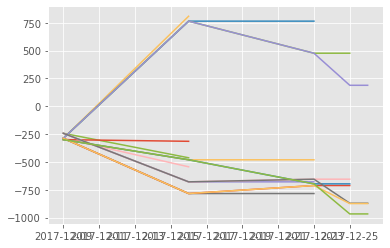

In [71]:
main()